# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Loading" data-toc-modified-id="Loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading</a></div><div class="lev1 toc-item"><a href="#T-cells" data-toc-modified-id="T-cells-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>T cells</a></div><div class="lev2 toc-item"><a href="#Clonal-families" data-toc-modified-id="Clonal-families-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Clonal families</a></div><div class="lev3 toc-item"><a href="#TCR-beta-/-delta" data-toc-modified-id="TCR-beta-/-delta-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>TCR beta / delta</a></div><div class="lev3 toc-item"><a href="#TCR-alpha-/-gamma" data-toc-modified-id="TCR-alpha-/-gamma-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>TCR alpha / gamma</a></div><div class="lev4 toc-item"><a href="#Lineage-identities" data-toc-modified-id="Lineage-identities-2.1.2.1"><span class="toc-item-num">2.1.2.1&nbsp;&nbsp;</span>Lineage identities</a></div><div class="lev1 toc-item"><a href="#B-cells" data-toc-modified-id="B-cells-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>B cells</a></div><div class="lev2 toc-item"><a href="#Gene-usage:-no-different-between-infected-and-uninfected-B-cells-(heavy-or-light)" data-toc-modified-id="Gene-usage:-no-different-between-infected-and-uninfected-B-cells-(heavy-or-light)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Gene usage: no different between infected and uninfected B cells (heavy or light)</a></div><div class="lev2 toc-item"><a href="#V-identity:-infected-IgM-are-less-mutated" data-toc-modified-id="V-identity:-infected-IgM-are-less-mutated-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>V identity: infected IgM are less mutated</a></div><div class="lev2 toc-item"><a href="#Paired-CDR3-heavy-/-light-chain-lengths" data-toc-modified-id="Paired-CDR3-heavy-/-light-chain-lengths-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Paired CDR3 heavy / light chain lengths</a></div><div class="lev2 toc-item"><a href="#Clonal-families" data-toc-modified-id="Clonal-families-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Clonal families</a></div>

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from itertools import combinations, product
import Levenshtein
import graph_tool.all as gt 
%matplotlib inline

/home/derek/resources/anaconda/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:1468: RuntimeWarning: Error importing Gtk module: No module named gi; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [2]:
import matplotlib as mpl
# for exporting vector graphics text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# style
sns.set_context('paper', font_scale=0.9)
sns.set_style('whitegrid')

# Loading

In [3]:
%%bash
git clone https://github.com/dcroote/btreceptor
# clone repo that contains B/TCR utility functions

Cloning into 'btreceptor'...


In [4]:
sys.path.append('btreceptor/')  # default path to btreceptor repo cloned in cell above
import btreceptor as btr

In [5]:
################################################
# load long format aggregate assembly dataframes

ab = pd.read_csv('../../data/tcell_ab_df.tsv', sep='\t')  # alpha-beta t cell
gd = pd.read_csv('../../data/tcell_gd_df.tsv', sep='\t')  # gamma-delta t cell
bc = pd.read_csv('../../data/bcell_df.tsv', sep='\t')     # b cell

# combined alpha-beta and gamma-delta dataframe
tc = ab.append(gd).reset_index(drop=True)

# list of all experiments (patient uids) in study
all_exps = [10017011, 10017012, 10017013, 10017014, 10017015, 10017016, 10017017, 10017018, 10017021, 10017022]

In [6]:
#############
# data checks

# assert single heavy and light chain for each cell (beta & delta are heavy while alpha and gamma are light for T cells)
for frame in [ab, gd, bc]:
    assert frame.groupby('cell').apply(lambda x: x[~x.heavy].shape[0] == 1 & x[x.heavy].shape[0] == 1).all()

# assert cells don't have a multiple types of TCR or have a TCR and BCR
for f1, f2 in combinations([ab, gd, bc], 2):
    assert not set(f1.cell) & set(f2.cell)

# T cells

## Clonal families

In [7]:
########################################
# add node property columns for drawing

# node stroke- alpha/beta have heavy stroke compared to delta/gamma
tc['node_stroke'] = tc.c_region.apply(lambda x: 1.25 if x in ['TRA', 'TRB'] else 0.5)

# node shape- disease status
tcell_shape_dict = {'control': 'circle', 'dengue_fever': 'triangle', 'severe_dengue': 'square'}
tc['node_shape'] = tc.disease_status.apply(lambda x: tcell_shape_dict[x])

# node color- experiment (patient)
set3_colors = sns.color_palette("Set3", n_colors=11).as_hex()
set3_colors.pop(1)  # get rid of horrible yellow

tcell_color_dict = {k:v for k,v in zip(all_exps, set3_colors)}
tc['node_color'] = tc.experiment.apply(lambda x: tcell_color_dict[x])

# uncomment below to show experiments / colors:
# print(all_exps)
# sns.palplot(sns.color_palette([tcell_color_dict[x] for x in all_exps]))

### TCR beta / delta

In [8]:
# cluster on beta / delta
bd_lins = btr.clustering.df_add_lineages(tc[tc.heavy], 0.8)

bdvc = bd_lins.lineage.value_counts()
bdvc.value_counts().sort_index()  # number of lineages with X members

1     721
2      26
3       8
4       4
5       1
6       1
8       1
15      1
Name: lineage, dtype: int64

In [9]:
# multi member lineages
bd_mmlins = bd_lins[(bd_lins.lineage.isin(bdvc[bdvc > 1].index))].copy().sort_values('lineage')

print('Unique CFs:\t{}'.format(len(bd_mmlins.lineage.unique())))
print('Unique cells:\t{}'.format(bd_mmlins.shape[0]))  # ... previously 192...

Unique CFs:	42
Unique cells:	126


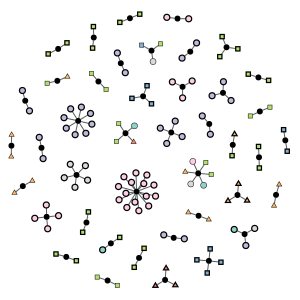

In [10]:
node_dict = btr.drawing.df_generate_node_dict(bd_mmlins)

f = plt.figure(figsize=(3,1.7))
with sns.axes_style('white'):
    btr.drawing.draw_gviz(node_dict, size_multiple=6, output_size=(300, 300))

### TCR alpha / gamma

In [11]:
# cluster on alpha / gamma
ag_lins = btr.clustering.df_add_lineages(tc[~tc.heavy], 0.8)
agvc = ag_lins.lineage.value_counts()
agvc.value_counts().sort_index()  # number of lineages with X members

1     613
2      27
3       4
4       2
5       2
6       1
8       1
9       1
14      1
19      1
36      1
58      1
Name: lineage, dtype: int64

In [12]:
# multi member lineages
ag_mmlins = ag_lins[(ag_lins.lineage.isin(agvc[agvc > 1].index))].copy().sort_values('lineage')
print('Unique CFs:\t{}'.format(len(ag_mmlins.lineage.unique())))
print('Unique cells:\t{}'.format(ag_mmlins.shape[0]))  # ... previously 192...

Unique CFs:	42
Unique cells:	234


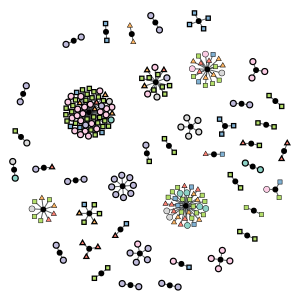

In [13]:
ag_node_dict = btr.drawing.df_generate_node_dict(ag_mmlins)

f = plt.figure(figsize=(3,1.7))
with sns.axes_style('white'):
    btr.drawing.draw_gviz(ag_node_dict, size_multiple=6, output_size=(300,300))

#### Lineage identities

In [14]:
def call_mait(dfin):
    """ Returns bool for whether lineage is MAIT i.e. has specific alpha V / J genes """
    mait_percent = ((dfin.v_call.str.startswith('TRAV1-2')) & ((dfin.j_call.str.startswith('TRAJ33')) | (dfin.j_call.str.startswith('TRAJ12')) | (dfin.j_call.str.startswith('TRAJ20')))).value_counts(normalize=True)
    if True in mait_percent.index and mait_percent.loc[True] > 0.75:
        return True
    else:
        return False

In [15]:
def call_lineage_chain(dfin):
    c_region = dfin.c_region.unique()
    if len(c_region) == 1:
        return c_region[0]
    else:
        return ', '.join(c_region)

In [16]:
def call_inkt(dfin, complete_df):
    """ iNKT defined by TRAV10-TRAJ18 / TRBV25-1 
        Args:
            dfin (pd.DataFrame): DataFrame subset to a given lineage
            complete_df (pd.DataFrame): DataFrame containing BOTH chains
                (since lineages are formed by heavy or light)
    """
    is_inkt = False
    
    # check alpha
    if dfin.v_call.str.contains('TRAV10').all() & dfin.j_call.str.contains('TRAJ18').all():
        # check beta
        corresponding_beta = complete_df[(complete_df.cell.isin(dfin.cell)) & (complete_df.c_region=='TRB')]
        if corresponding_beta.v_call.str.contains('TRBV25').all():
            is_inkt = True
            
    return is_inkt

In [17]:
lineage_info = pd.concat([ag_mmlins.lineage.value_counts().rename('num_cells'),
                          ag_mmlins.groupby('lineage').apply(call_lineage_chain).rename('chain'),
                          ag_mmlins.groupby('lineage').apply(call_mait).rename('is_MAIT'),
                          ag_mmlins.groupby('lineage').apply(call_inkt, complete_df=tc).rename('is_iNKT'),
                          ag_mmlins.groupby('lineage').apply(lambda x: pd.Series({'most_common_cdr3': x.cdr3aa.value_counts().index[0], 'cnt_of_most_common_cdr3': x.cdr3aa.value_counts().values[0]}))
                         ], axis=1).sort_values('num_cells', ascending=False).head(8)
lineage_info

,num_cells,chain,is_MAIT,is_iNKT,cnt_of_most_common_cdr3,most_common_cdr3
lineage,,,,,,
21,58,TRA,True,False,17,AVVDSNYQLI
781,36,TRG,False,False,7,ALWEVQELGKKIKV
820,19,TRG,False,False,2,ALWEVLQELGKKIKV
85,14,TRA,False,True,12,VVSDRGSTLGRLY
772,9,TRG,False,False,2,ALWVQELGKKIKV
640,8,TRA,False,False,8,ALAPPNQAGTALI
3,6,TRA,True,False,2,AVMDSSYKLI
334,5,TRA,False,False,5,ALSEARNFNKFY


# B cells

## Gene usage: no different between infected and uninfected B cells (heavy or light)

In [18]:
def gene_usage_plot(vcbc, title='', figpath=None):
    
    gusage = vcbc.copy()
    _vmax = gusage.v_genenum.max()
    _jmax = gusage.j_genenum.max()

    f,ax = plt.subplots(1,2, figsize=(3,1.4), sharex=True, sharey=True)
    ax=ax.ravel()

    for c,virus in enumerate([True, False]):
        pivoted = gusage[gusage.has_virus == virus].pivot_table(index='j_genenum', columns='v_genenum', values='cnt').sort_index(ascending=False)
        pivoted = pivoted.reindex(columns=range(1,_vmax+1)).reindex(index=range(_jmax, 0, -1))
        pivoted.fillna(0, inplace=True)
        pivoted.index.name = 'J gene'
        pivoted.columns.name = 'V gene'
        
        if c==1:
            cbarkws = {'label': 'Number of cells'}
        else:
            cbarkws = {}
        
        sns.heatmap(data=pivoted, cmap='Reds', ax=ax[c], cbar_kws=cbarkws, mask=pivoted==0)
        for _, spine in ax[c].spines.items():
            spine.set_visible(True)
        
        if c==1:
            ax[c].set_ylabel('')

        if virus:
            ax[c].set_title('Virus')
        else:
            ax[c].set_title('No virus')

    f.tight_layout()
    f.suptitle(title, y=1.05)
    
    if figpath:
        for fmt in ['pdf','png','svg']:
            f.savefig('{}.{}'.format(figpath, fmt))

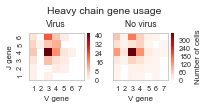

In [19]:
heavy_gene_usage = bc[bc.heavy].groupby(['has_virus','v_genenum']).j_genenum.value_counts().reset_index(name='cnt')
gene_usage_plot(heavy_gene_usage, title='Heavy chain gene usage')

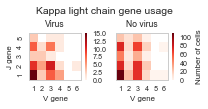

In [20]:
########
# KAPPA

kappa_gene_usage = bc[bc.c_region=='IGKC'].groupby(['has_virus','v_genenum']).j_genenum.value_counts().reset_index(name='cnt')
gene_usage_plot(kappa_gene_usage, title='Kappa light chain gene usage')

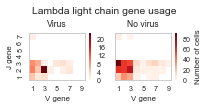

In [21]:
########
# LAMBDA

lambda_gene_usage = bc[bc.c_region=='IGLC'].groupby(['has_virus','v_genenum']).j_genenum.value_counts().reset_index(name='cnt')
gene_usage_plot(lambda_gene_usage, title='Lambda light chain gene usage')

## V identity: infected IgM are less mutated

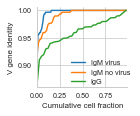

In [22]:
f,ax = plt.subplots(figsize=(2,1.7))
for virus in [True, False]:
    tmp = bc[(bc.c_region=='IGHM') & (bc.has_virus==virus) & (bc.experiment.isin([10017016, 10017022]))].sort_values('v_identity').v_identity.reset_index(drop=True)
    tmp.index /= tmp.shape[0] # cumulative frac
    tmp.plot(ax=ax)

# IgG1 for reference
tmp = bc[(bc.c_region=='IGHG1') & (bc.experiment.isin([10017016, 10017022]))].sort_values('v_identity').v_identity.reset_index(drop=True)
tmp.index /= tmp.shape[0]
tmp.plot(ax=ax)

ax.legend(['IgM virus', 'IgM no virus', 'IgG'], loc=4, bbox_to_anchor=(1.1,-.05))
ax.set_xlabel('Cumulative cell fraction')
ax.set_ylabel('V gene identity')

sns.despine()
f.tight_layout()

## Paired CDR3 heavy / light chain lengths

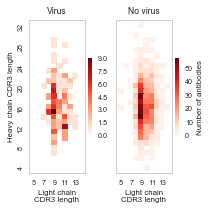

In [23]:
f,ax = plt.subplots(1,2, figsize=(3,3), sharex=True, sharey=True)
ax=ax.ravel()

# min / max ranges for heavy and light
hmax = bc[bc.heavy].cdr3aa_len.max()
hmin = bc[bc.heavy].cdr3aa_len.min()
lmax = bc[~bc.heavy].cdr3aa_len.max()
lmin = bc[~bc.heavy].cdr3aa_len.min()

for c, virus in enumerate([True, False]):
    
    paired = bc[bc.has_virus==virus].pivot(index='cell', columns='heavy', values='cdr3aa')
    paired.rename(columns={True: 'hcdr3', False: 'lcdr3'}, inplace=True)
    paired['hcl'] = paired.hcdr3.str.len()
    paired['lcl'] = paired.lcdr3.str.len()
    ppt = paired.groupby('hcl').lcl.value_counts().reset_index(name='cnt').pivot_table(index='hcl', columns='lcl', values='cnt').fillna(0)
    # add missing rows / columns by reindexing, filling with zero
    ppt = ppt.reindex(index=range(hmax, hmin-1, -1), columns=range(lmin, lmax+1), fill_value=0)
    cbkws = {'shrink':0.5}
    if c==1:
        cbkws.update({'label': 'Number of antibodies'})
    sns.heatmap(ppt, square=True, cmap="Reds", ax=ax[c], cbar_kws=cbkws, mask=ppt==0)
    
    for _, spine in ax[c].spines.items():
        spine.set_visible(True)
    
    if virus:
        ax[c].set_title('Virus')
    else:
        ax[c].set_title('No virus')
    
ax[1].set_ylabel('')
ax[0].set_ylabel('Heavy chain CDR3 length')
for i in [0,1]:
    ax[i].set_xlabel('Light chain\nCDR3 length')
ax[0].set_yticklabels(ax[0].get_yticklabels()[::2])
ax[0].set_yticks(ax[0].get_yticks()[::2])

f.tight_layout()

## Clonal families

In [24]:
########################################
# generate desired node property columns

# node shape- experiment (patient)
bcell_shape_dict = {10017014: 'circle', 10017015: 'triangle'}  # only these patients have cells in multi-member lineages
bc['node_shape'] = bc.experiment.apply(lambda x: bcell_shape_dict[x] if x in bcell_shape_dict else 'square')

isotype_color_dict = {'germline':'black', 'IGHA1': '#6EAD7E', 'IGHA2': '#AADDBF', 'IGHG1': '#885F89', 'IGHG2': '#CC90CE', 'IGHG3': '#FBB5FF',
                      'IGHE': '#F98174', 'IGHG4': '#81B1D1', 'IGHM': '#898989', 'IGHD': '#C6C6C6',
                      'IGLC': '#C0C0C0', 'IGKC': '#404040'}

bc['node_color'] = bc.c_region.apply(lambda x: isotype_color_dict[x])

bc['node_size'] = 1 - bc.v_identity + 0.01

# uncomment below to show experiments / colors:
# print(all_exps)
# sns.palplot(sns.color_palette([tcell_color_dict[x] for x in all_exps]))

In [25]:
# cluster antibody heavy chain
bc_lins = btr.clustering.df_add_lineages(bc[bc.heavy], 0.8)
bcvc = bc_lins.lineage.value_counts()
bcvc.value_counts().sort_index()  # number of lineages with X members

1    1440
2      11
3       2
6       2
Name: lineage, dtype: int64

In [26]:
# multi member lineages
bc_mmlins = bc_lins[(bc_lins.lineage.isin(bcvc[bcvc > 1].index))].copy().sort_values('lineage')
print('Unique CFs:\t{}'.format(len(bc_mmlins.lineage.unique())))
print('Unique cells:\t{}'.format(bc_mmlins.shape[0]))  # ... previously 192...

Unique CFs:	15
Unique cells:	40


In [27]:
bc_mmlins.experiment.value_counts()

10017014    30
10017015    10
Name: experiment, dtype: int64

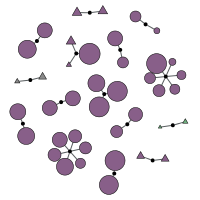

In [28]:
bc_node_dict = btr.drawing.df_generate_node_dict(bc_mmlins)

f = plt.figure(figsize=(3,1.7))
with sns.axes_style('white'):
    btr.drawing.draw_gviz(bc_node_dict, size_multiple=180, output_size=(200,200))